### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# <font color="white">1. Environment Setup</font>

Install and activate the tensorflow27_p37_cpu_v1 conda pack

In [79]:
!pip install tensorflow_datasets

# <font color="white">2. Importing the Libraries</font>

In [80]:
import ads
import logging
import os
import pandas as pd
import tempfile
import tensorflow as tf
import tensorflow_datasets as tads
import warnings

from ads.catalog.model import ModelCatalog
from ads.model.model_metadata import UseCaseType

from ads.dataset.factory import DatasetFactory
from ads.model.framework.tensorflow_model import TensorFlowModel
from shutil import rmtree
ads.set_auth(auth='resource_principal')

logging.basicConfig(format='%[levelname]s:%[message]s',level=logging.ERROR)
warnings.filterwarnings('ignore')


# <font color="white">3. Loading the Dataset</font>

## <font color="white">3.1 Downloading the Dataset</font>

In [81]:
fminst=tf.keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test)=fminst.load_data()

## <font color="white">3.2 Dataset Description</font>

The Fashion_MNIST is a dataset of Zalardos article images. Its breakdown is a follows:
- It has a training set of 60,000 images
- It has a testing set of 10,000 images
- Each of the images is a 28px*28px grayscale associated with a label from 10 classes
- Each pixel is between 0 - 255
- The dataset has 785 columns with the labels being in the first column

## <font color="white">3.3 Dataset Visualization</font>

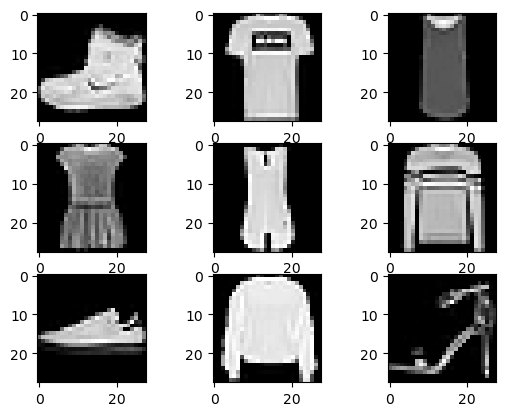

In [82]:
from matplotlib import pyplot as plt

for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(x_train[i],cmap='gray')
plt.show()

## <font color="white">3.4 Creating the TensorFlow Model</font>

### <font color="white">3.4.1 Initializing the Model Class</font>

We create a TensorFlow class to do the following:
- Downloads the FMNIST dataset
- Scales the data to between 0 and 1 
- Only the first 10,000 training samples are used to reduce computation time for model generation
- The tensor flow model is then created containing the following:
    - Input layer of 784 columns of the 28*28 images
    - A dense layer of 128 neutrons with a relu activation setting
    - a 20% dropout to avoid overfitting
    - An dense output layer containing 10 neurons representing the 10 classes in the dataset

In [83]:
class TFModel:
    fminst=tf.keras.datasets.fashion_mnist
    (x_train,y_train),(x_test,y_test)=fminst.load_data()#downloads and stores the train,test sets
    x_train,x_test=x_train/255,x_test/255 #scale between 0 and 1
    x_train,y_train=x_train[:10000],y_train[:10000] # Reduce training data
    
    #define the training function
    def training(self):
        # Initialize the model
        model= tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28,28)),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10)
        ])
        # Defines the loss function
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        # Compile the model
        model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])
        # Train the model
        model.fit(self.x_train,self.y_train,epochs=1)
        # Return the trained model
        return model

### <font color="white">3.4.2 Running and Training the Model</font>

Running and Training the model from the TFModel Class

In [84]:
model=TFModel().training()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7265 - loss: 0.7900


### <font color="white">3.4.3 Model Predictions</font>

Model Prediction
- We then create a prediction using a test set passed to the predict method
- Each prediction outputs 10 values since there are 10 nodes on the output
- The node with the highest value is the predicted digit


In [85]:
model.predict(TFModel().x_test[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([[-4.362089 , -3.8880284, -3.0444667, -3.371047 , -4.5876656,
         3.0824497, -2.7359307,  3.0371804,  1.4472779,  4.476155 ]],
      dtype=float32)

### <font color="white">3.4.4 Verifying the Prediction</font>

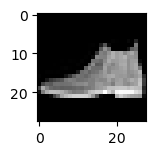

In [86]:
plt.subplot(330+1+1)
plt.imshow(x_test[0],cmap='gray')
plt.show()

## <font color="white">4. Tensor Flow Model Serialization</font>

Model Serialization in Tensorflow allows for the model to be deployed to production using the following steps

### <font color="white">4.1 Creating the model artefact directory</font>

In [87]:
artifact_dir='/home/datascience/Acquiredskills_demos/Cloud_Development/Oracle_Cloud_Data_Science/serialized_models'


### <font color="white">4.2 Converting the Model to an Object</font>
- Using the TensorFlowModel() constructor to convert a Tensor flow model to an object
- This object is used to manage the deployment

In [88]:
print(f'Model artefact directory: {artifact_dir}')
tf_model=TensorFlowModel(estimator=model,artifact_dir=artifact_dir)

Model artefact directory: /home/datascience/Acquiredskills_demos/Cloud_Development/Oracle_Cloud_Data_Science/serialized_models


### <font color="white">4.3 Tracking the Serialization Process</font>
We can track progress of our serialisation process using summary_status()

In [89]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Available     Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Not Available Local tested .predict from score.py                               
save()    Not Available Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  UNKNOWN       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

### <font color="white">4.4 Preparing the Model</font>
The prepare() method is used to prepare the model for deployment. It creates several customized files which include:
- input_schema.json - A JSON File which defines the nature of the features of the X_Sample. It includes metadata such as 
    - data type,name,constraints, summary statistics,feature_type
- model.h5: this is the default filename of the serialised model stored using the h5 file extension you can use the as_onnx to save it
- output_schema.json: A JSON File that defines the nature of the dependent variable in the y_sample data.It includes metadata such as 
    - data type,name,constraints, summary statistics,feature_type
- runtime.yaml: Contains information needed to setup the runtime environment on server. it contains information such as 
    -  Conda environment used for training, python version, and the deployment conda environment
- score.py: Contains
    -  load_model() function: Understands the format the model was saved in and loads it into memory.
    - predict() function: Used to make inferences from the model

In [90]:
conda_env='tensorflow27_p37_cpu_v1'

tf_model.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    use_case_type=UseCaseType.MULTINOMIAL_CLASSIFICATION,
    X_sample=TFModel().x_test,
    y_sample=TFModel().y_test,
    force_overwrite=True
)

algorithm: Sequential
artifact_dir:
  /home/datascience/Acquiredskills_demos/Cloud_Development/Oracle_Cloud_Data_Science/serialized_models:
  - - output_schema.json
    - .model-ignore
    - test_json_output.json
    - runtime.yaml
    - model.h5
    - score.py
framework: tensorflow
model_deployment_id: null
model_id: null

#### <font color="white">4.4.1 List the Generated Deployment Files</font>

In [92]:
os.listdir(artifact_dir)

['output_schema.json',
 '.model-ignore',
 'test_json_output.json',
 'runtime.yaml',
 'model.h5',
 'score.py']

#### <font color="white">4.4.2 Tracking the Serialization Process</font>
We can track progress of our serialisation process using summary_status()

In [93]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  UNKNOWN       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

#### <font color="white">4.4.3 Inspecting the prepared model artefact</font>

##### <font color="white">4.4.3.1 Viewing the Model runtime environment</font>

In [94]:
tf_model.runtime_info


model_artifact_version: '3.0'
model_deployment:
  inference_conda_env:
    inference_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow_2.7_for_CPU_on_Python_3.7/1.0/tensorflow27_p37_cpu_v1
    inference_env_slug: tensorflow27_p37_cpu_v1
    inference_env_type: data_science
    inference_python_version: '3.7'
model_provenance:
  project_ocid: ''
  tenancy_ocid: ''
  training_code:
    artifact_directory: /home/datascience/Acquiredskills_demos/Cloud_Development/Oracle_Cloud_Data_Science/serialized_models
  training_compartment_ocid: ''
  training_conda_env:
    training_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow_2.7_for_CPU_on_Python_3.7/1.0/tensorflow27_p37_cpu_v1
    training_env_slug: tensorflow27_p37_cpu_v1
    training_env_type: data_science
    training_python_version: '3.7'
  training_region: ''
  training_resource_ocid: ''
  user_ocid: ''
  vm_image_internal_id: ''

##### <font color="white">4.4.3.2 Viewing the Model schema</font>

The .schema_input shows the following information
- Features used to train the model
- For each feature there is a section showing datatype,feature type, its name and if it is required\

In [95]:
tf_model.schema_input

schema: []
version: '1.1'

#### <font color="white">4.4.3.3 Viewing the Model Custom metadata</font>
The .metadata_custom attribute provides custom metadata that contains information on:
- Category of metadata
- description
- key and value pairs

In [96]:
tf_model.metadata_custom

data:
- category: Training Environment
  description: The conda environment where the model was trained.
  has_artifact: false
  key: CondaEnvironment
  value: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow_2.7_for_CPU_on_Python_3.7/1.0/tensorflow27_p37_cpu_v1
- category: Training Profile
  description: The model serialization format.
  has_artifact: false
  key: ModelSerializationFormat
  value: h5
- category: Training Environment
  description: The URI of the training conda environment.
  has_artifact: false
  key: CondaEnvironmentPath
  value: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow_2.7_for_CPU_on_Python_3.7/1.0/tensorflow27_p37_cpu_v1
- category: Training Environment
  description: The list of files located in artifacts folder.
  has_artifact: false
  key: ModelArtifacts
  value: output_schema.json, .model-ignore, test_json_output.json, runtime.yaml, model.h5,
    score.py
- category: Training Environment
  description: The conda envir

##### <font color="white">4.4.3.4 Viewing the Model provenance</font>
The .metadata_provenance contains information about the code and training data used to create the model.

In [97]:
tf_model.metadata_provenance


artifact_dir: /home/datascience/Acquiredskills_demos/Cloud_Development/Oracle_Cloud_Data_Science/serialized_models
git_branch: master
git_commit: cad5e14cacd61bd1ce577bda5f2454d7f2db7382
repository_url: https://github.com/jeffrey990macharia0/Acquiredskills_demos.git
training_id: ocid1.datasciencenotebooksession.oc1.phx.amaaaaaar5iot3iajwxam43gqcyuefyqx7jpyzo3wo6am4vujqsoonvdkl4a
training_script_path: null

#### <font color="white">4.4.3.5 Viewing the model taxonomy</font>
This is a key value pair information about the model. It contains information such as
- model framework
- use case type
- hyperparameters

In [98]:
tf_model.metadata_taxonomy

data:
- has_artifact: false
  key: Algorithm
  value: Sequential
- has_artifact: false
  key: Framework
  value: tensorflow
- has_artifact: false
  key: FrameworkVersion
  value: 2.20.0
- has_artifact: false
  key: UseCaseType
  value: multinomial_classification
- has_artifact: false
  key: Hyperparameters
  value: null
- has_artifact: false
  key: ArtifactTestResults
  value: null

### <font color="white">4.5 Verifying the Model</font>
if you make changes to the score.py file which is part of the model artefact, it should be verified.
 
This allows the code to be debugged without having to save the model to the catalog

The verify method takes a set of parameters and performs predictions by calling the predict() function

In [99]:
tf_model.verify(TFModel().x_test[0:1])

Start loading model.h5 from model directory /home/datascience/Acquiredskills_demos/Cloud_Development/Oracle_Cloud_Data_Science/serialized_models ...
Model is successfully loaded.


{'prediction': [[-4.362089157104492,
   -3.888028383255005,
   -3.044466733932495,
   -3.371047019958496,
   -4.587665557861328,
   3.0824496746063232,
   -2.7359306812286377,
   3.0371804237365723,
   1.4472779035568237,
   4.476154804229736]]}

### <font color="white">4.5.1 Track the Model Serialization</font>

In [100]:
tf_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  UNKNOWN       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

### <font color="white">4.6 Saving the Model</font>

This process saves the model to the model catalog and returns its OCID

In [101]:
model_id=tf_model.save(display_name='Demo FMNIST TensorFlow Model')

Start loading model.h5 from model directory /home/datascience/Acquiredskills_demos/Cloud_Development/Oracle_Cloud_Data_Science/serialized_models ...
Model is successfully loaded.
['output_schema.json', '.model-ignore', 'test_json_output.json', 'runtime.yaml', 'model.h5', 'score.py']


ERROR - Exception
Traceback (most recent call last):
  File "/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_25949/3824151614.py", line 1, in <module>
    model_id=tf_model.save(display_name='Demo FMNIST TensorFlow Model')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/ads/model/generic_model.py", line 2211, in save
    self.dsc_model = (
                     ^
  File "/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/site-packages/ads/model/datascience_model.py", line 1260, in create
    self.dsc_model = self._to_oci_dsc_model(**kwargs).create()
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/datascience/conda/automlx251_p311_cpu_x86_64_v2/lib/python3.11/si